<a href="https://colab.research.google.com/github/Sovit1056/Pytorch_practice/blob/main/04_Pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.4 PyTorch Custom Datasets

We've ued some datasets with pytorch before.

BUt now we will use our own data via: custom datasets.

## Domain Libraries: https://pytorch.org/domains/

Depending on what we are working on:
* Vision: https://docs.pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets
* Text :
* Audio
* Recommendation: like in social media plaform
* Different other data
We'll look into the PyTorch domain libraries for existing data loading function and customize data loading function.

**Resources:**
* Book Version: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## What are we going to cover

* Getting a **custom data** with pytorch
* Preaparing and visualizing our data
* **Transforming data** for use with a model
* **Loading custom data** with pre-built function and custom function
* Building computer vision **model**
* Comparing model with and without **Data augmentation**
* **Making prediction** on custom data.

### Things remain to learn

* Code to creat our own **custom data** set.

## 0. Import Libraries and Setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Seetting the device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!nvidia-smi

Mon Jul 21 04:36:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

* Tutors dataset is a subset of the Food101 dataset.

* Food101 starts 101 different class of food and 1000 images per class (750 training, 250 testing).

* Tutors dataset starts with 3 classes of food and only 10% of the images ( i.e 75 training and 25 testing)

  Why this?

  * When starting out ML project, it's important to try things on small scale and then increase the scale when done.
  * It is to speed up our experiment

### Importing Zip file from Github

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnot exist, download and unzip it......
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data: we can also download in local drive from github and upload without coding tooo.
with open (data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip file:

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file...")
    zip_ref.extractall(image_path)



Did not find data/pizza_steak_sushi directory, creating one...
Unzipping the file...


In [4]:
# reset our working directory to /content, where your uploads, mounts, and downloaded files are normally accessible

%cd /content


/content


## 2. Data preparation and Data exploration

In [5]:
import os
def walk_through_dir(dir_path):
  # Walking through dir_path returing its contents.
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and test paths

train_dir = image_path / "train"  # look how to crete the path as from data_path = Path("data/") and image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

We can directly look from the dataset folder.

But let's try to visualize the image using code.
1. Get all of the image path.
2. Pick a random image path through `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open image with Python's PIL (pillow): https://pypi.org/project/pillow/
5. We'll then show image and print metadata.

| **Function / Setting**                      | **Library / Module**            | **Purpose**                                                       | **Controls**                                                                                                 | **Notes**                                                  |
| ------------------------------------------- | ------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------- |
| `random.seed(seed)`                         | Python built-in `random` module | Sets seed for Python's default pseudo-random number generator.    | Affects `random.random()`, `random.randint()`, `random.shuffle()`, etc.                                      | Does **not** affect NumPy or PyTorch randomness.           |
| `np.random.seed(seed)`                      | NumPy                           | Sets seed for NumPy's PRNG.                                       | Controls NumPy functions like `np.random.rand()`, `np.random.randn()`, etc.                                  | Does **not** affect Python `random` or PyTorch randomness. |
| `torch.manual_seed(seed)`                   | PyTorch                         | Sets seed for PyTorch's CPU and general PRNG.                     | Controls PyTorch functions like `torch.rand()`, `torch.randn()`, weight initialization, data shuffling, etc. | Recommended for all PyTorch workflows.                     |
| `torch.cuda.manual_seed(seed)`              | PyTorch CUDA                    | Sets seed for **CUDA PRNG** on current GPU.                       | Controls PyTorch CUDA random operations.                                                                     | Needed for reproducibility in GPU computations.            |
| `torch.cuda.manual_seed_all(seed)`          | PyTorch CUDA (multi-GPU)        | Sets seed for all GPUs.                                           | Controls CUDA randomness across all GPUs in multi-GPU setups.                                                | Use in multi-GPU training.                                 |
| `torch.backends.cudnn.deterministic = True` | PyTorch cuDNN backend           | Forces deterministic algorithms in cuDNN.                         | Makes convolution and similar operations reproducible.                                                       | May slightly reduce training speed.                        |
| `torch.backends.cudnn.benchmark = False`    | PyTorch cuDNN backend           | Disables auto-tuner for selecting fastest convolution algorithms. | Prevents non-deterministic algorithm selection.                                                              | Setting to `False` ensures reproducibility.                |


Random image path: data/pizza_steak_sushi/train/pizza/1649276.jpg
Image class: pizza
Image class path: data/pizza_steak_sushi/train/pizza

Image size: (512, 384)

Image mode: RGB

Image format: JPEG

Image height: 384

Image width: 512

Image info: {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72), 'comment': b'Motorola\nMOTOQA1\nA2.01.11R\n2012:04:24 12:14:11\n', 'exif': b'Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x0c\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\x9e\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa6\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x0e\x00\x02\x00\x00\x00\x19\x00\x00\x00\xae\x01\x0f\x00\x02\x00\x00\x00\n\x00\x00\x00\xc7\x01\x10\x00\x02\x00\x00\x00\x19\x00\x00\x00\xd1\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xea\xa3\x03\x00\x01\x00\x00\x00\x08\x00\x00\x00\xfe\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x01\x95\x01\x12\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x011\x00\x02\x00

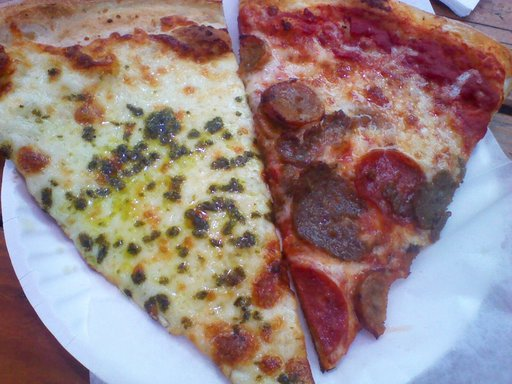

In [7]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))  # 1* is for trian and test / 2* is for pizza, steak and sushi and 3* is for any image file.


# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"Random image path: {random_image_path}")

# 3. Get the image class name
image_class = random_image_path.parent.stem   # parent is data/pizza_steak_sushi/train/sushi/ and stem is he end of that folder pizza
print(f"Image class: {image_class}")
print(f"Image class path: {random_image_path.parent}")

# 4. Open image : from the PIL but we can do this from Pytorch also like read
img = Image.open(random_image_path)

# 5. Print metadata
print(f"\nImage size: {img.size}")
print(f"\nImage mode: {img.mode}")
print(f"\nImage format: {img.format}")
print(f'\nImage height: {img.height}')
print(f'\nImage width: {img.width}')
print(f'\nImage info: {img.info}')
print(f"\n Image class: {image_class}")
img



(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

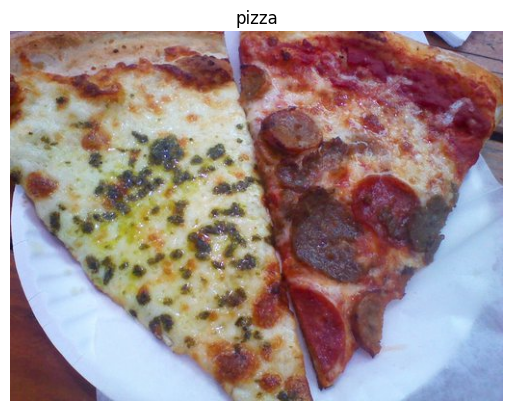

In [10]:
# Visualizing the data with matplotlib

import numpy as np  # to change the image into array
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(image_class)
plt.axis(False)



(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

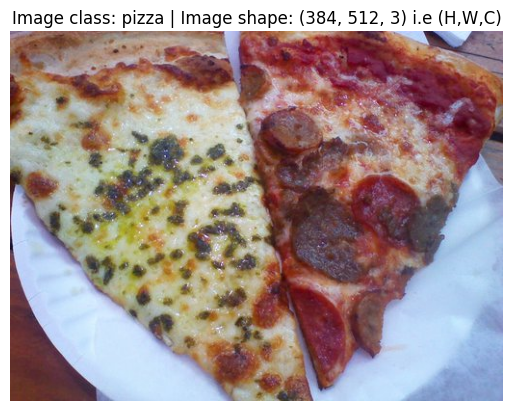

In [13]:
# Trun the image into an numpy array
img_as_array = np.asarray(img)
img_as_array.shape
plt.imshow(img)
plt.title(image_class)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} i.e (H,W,C)")
plt.axis(False)

## 3. Transforming data into tensor

1. Trun our target data into tensor (in this case; numerical representaation of our image)
2. Trun it into a `torch.utils.data.Dataset` and then `torch.utils.data.DataLoader` (i.e iterable or batched version of data set): **Dataset** and **DataLoader**


In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`